In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_train_trans = pd.read_csv('../input/train_transaction.csv')
df_train_identity = pd.read_csv('../input/train_identity.csv')

df_train = df_train_trans.merge(df_train_identity, how='left', on='TransactionID')

print(df_train.shape)

(590540, 434)


In [4]:
# Reduce memory usage
df_train = reduce_mem_usage(df_train)

start_mem Memory usage of df_train: 2513.97 MB
Mem. usage decreased to 1204.57 Mb (52.1% reduction)


In [5]:
# Label encoding for categorical features
for col in df_train.select_dtypes(include='object').columns:
    lbl = LabelEncoder()
        
    encoded_values = lbl.fit_transform(df_train[col]) 
        
    #Replace the NaN (which becomes -1 after LabelEncoding) with -999
    encoded_values[df_train[col].isnull()] = -999
        
    # Step 5: Assign the encoded values back to the column
    df_train[col] = encoded_values

df_train.fillna(-999, inplace=True)
percent_missing = (df_train == -999).mean() * 100

# Identify columns where more than 50% of the values are missing
cols_to_drop = percent_missing[percent_missing > 25].index

# Drop these columns
df_train_cleaned = df_train.drop(columns=cols_to_drop)

# Display the cleaned dataframe
print(f"Columns removed: {cols_to_drop}")
print(f"Shape of the cleaned dataframe: {df_train_cleaned.shape}")

Columns removed: Index(['dist1', 'dist2', 'R_emaildomain', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7',
       'D8',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=252)
Shape of the cleaned dataframe: (590540, 182)


In [6]:
# drop TransactionID because, it doesnt meaning, unique values is 590540
df_train_cleaned = df_train_cleaned.drop('TransactionID', axis=1)
df_train_cleaned.shape

(590540, 181)

In [7]:
X_train = df_train_cleaned.select_dtypes(include=['number']).drop(columns=['isFraud'])
y_train = df_train_cleaned['isFraud']  # This is the target variable

In [8]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

In [ ]:
# trying to applicate Oversampling
frauds = df_train_cleaned[df_train_cleaned.isFraud.eq(1)]

non_fradus = df_train_cleaned[df_train_cleaned.isFraud.eq(0)]

fraud_len = len(frauds)

under_sampled_non_frauds = non_fradus.sample(fraud_len)


under_samples = pd.concat([under_sampled_non_frauds, frauds])



under_samples

c:\Users\Matúš\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\Matúš\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
288907,3275907,0,7098567,26.953125,4,17188,321.0,150.0,3,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.000000
476627,3463627,0,12338447,42.937500,4,7207,111.0,150.0,3,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.000000
56861,3043861,0,1307408,1770.000000,4,7664,490.0,150.0,3,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,1769.949951,1769.949951,1769.949951
463403,3450403,0,11916954,53.968750,4,8414,253.0,150.0,2,224.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.000000
588860,3575860,0,15777334,59.000000,4,3166,559.0,150.0,3,166.0,...,34.0,29.0,63.0,63.0,0.0,0.0000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590361,3577361,1,15807368,1224.000000,4,3278,453.0,150.0,3,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.000000
590364,3577364,1,15807516,69.937500,0,5812,408.0,185.0,2,224.0,...,0.0,0.0,0.0,0.0,0.0,48.0774,0.0,0.000000,0.000000,0.000000
590368,3577368,1,15807677,100.000000,1,6758,399.0,150.0,0,146.0,...,0.0,-999.0,-999.0,-999.0,0.0,0.0000,0.0,0.000000,0.000000,0.000000
590372,3577372,1,15807758,117.000000,4,14037,111.0,150.0,3,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.000000


In [26]:
# Select only numerical columns
X_train = under_samples.drop(columns=['isFraud'])
y_train = under_samples['isFraud']

# Train-test split (80% train, 20% validation)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      4133
           1       0.89      0.87      0.88      4133

    accuracy                           0.88      8266
   macro avg       0.88      0.88      0.88      8266
weighted avg       0.88      0.88      0.88      8266



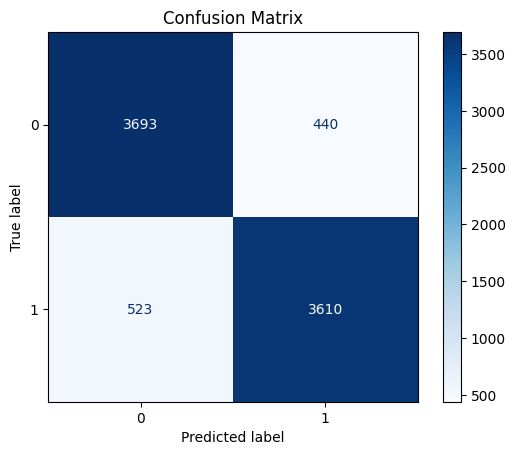

In [27]:
# Apply StandardScaler (fit only on train, transform on both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=300,
    random_state=42
)
# Train the model on PCA-transformed data
model.fit(X_train_scaled, y_train_final)

# Make predictions
y_val_pred = model.predict(X_val_scaled)

# Show classification report
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.14      0.24    113975
           1       0.04      0.97      0.08      4133

    accuracy                           0.16    118108
   macro avg       0.52      0.55      0.16    118108
weighted avg       0.96      0.16      0.23    118108



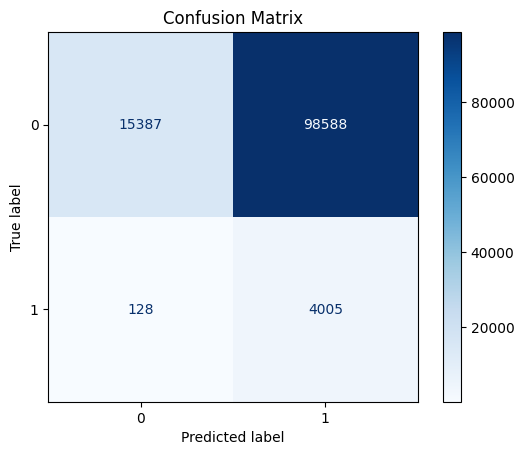

In [28]:
# Select only numerical columns
X_train = df_train_cleaned.drop(columns=['isFraud'])
y_train = df_train_cleaned['isFraud']

# Train-test split (80% train, 20% validation)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


# Apply StandardScaler (fit only on train, transform on both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

# Make predictions
y_val_pred = model.predict(X_val_scaled)

# Show classification report
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()